## Score Matching

A first important step is to realize that there's a convenient alternative to probability densities that let's us work with unnormalized functions: the so-called _score_. This is the name that was established for the gradient of the log likelihood function: $\nabla_x \log p(x)$. When we learn this function with a neural network, which we'll call $s_\theta(x)$ to indicate this is a learned _score_, the great thing is that we don't need to worry about normalization anymore. When integrating we'd need to have the right constant offset, but for the "local" gradients at $x$, all that matters is the derivative at this point.


### Gaussian Toy Dataset with Analytic Scores

In [4]:
import numpy as np

class GaussianMixture:
    def __init__(self, parameters):

        self.parameters = parameters
        self.distributions = [
            {
                'mean': np.array(dist['mean']),
                'std': np.array(dist['std']),
                'cov': np.diag(np.array(dist['std']) ** 2)
            }
            for dist in parameters
        ]

    def sample(self, num_samples):
        samples = []
        num_distributions = len(self.distributions)
        for _ in range(num_samples):
            idx = np.random.randint(num_distributions)
            dist = self.distributions[idx]
            sample = np.random.multivariate_normal(mean=dist['mean'], cov=dist['cov'])
            samples.append(sample)
        return np.array(samples)

    def likelihood(self, points):
        likelihoods = np.zeros(points.shape[0])
        for dist in self.distributions:
            mean = dist['mean']
            cov = dist['cov']
            inv_cov = np.linalg.inv(cov)
            det_cov = np.linalg.det(cov)

            factor = 1 / (2 * np.pi * np.sqrt(det_cov))
            diff = points - mean
            exponents = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            likelihoods += factor * np.exp(exponents)

        return likelihoods

    def score(self, points):

        scores = np.zeros_like(points)
        likelihoods = np.zeros(points.shape[0])

        component_likelihoods = []
        for dist in self.distributions:
            mean = dist['mean']
            cov = dist['cov']
            inv_cov = np.linalg.inv(cov)
            det_cov = np.linalg.det(cov)

            factor = 1 / (2 * np.pi * np.sqrt(det_cov))
            diff = points - mean
            exponents = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            comp_likelihood = factor * np.exp(exponents)

            component_likelihoods.append(comp_likelihood)
            likelihoods += comp_likelihood

        for dist, comp_likelihood in zip(self.distributions, component_likelihoods):
            mean = dist['mean']
            inv_cov = np.linalg.inv(dist['cov'])
            weights = comp_likelihood / (likelihoods + 1e-8)
            diff = points - mean
            component_score = -(diff @ inv_cov)
            scores += np.multiply(weights[:, np.newaxis], component_score)

        return scores

### Visualize Samples, Likelihoods and Scores

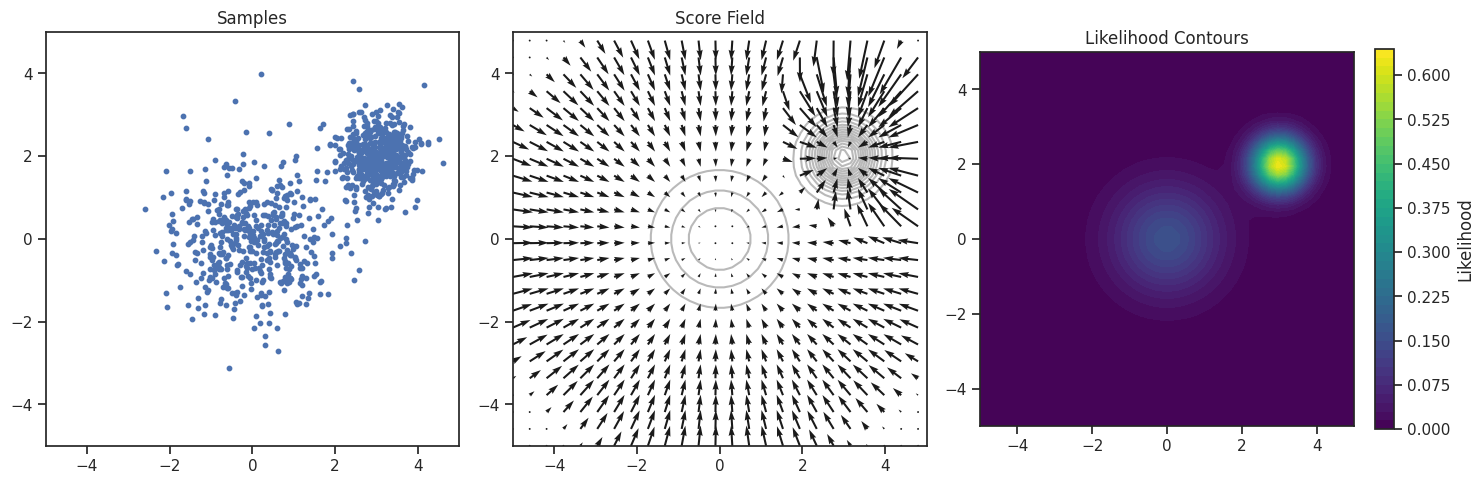

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

def visualize_gaussian_mixture_with_score(mixture, num_samples=1000, grid_size=50):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

    # Create grid for visualization
    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])

    # Compute likelihoods and scores
    likelihoods = mixture.likelihood(points)
    scores = mixture.score(points)
    samples = mixture.sample(num_samples)

    # Reshape for plotting
    likelihoods = likelihoods.reshape(grid_size, grid_size)
    scores_x = scores[:, 0].reshape(grid_size, grid_size)
    scores_y = scores[:, 1].reshape(grid_size, grid_size)

    ax1.scatter(samples[:, 0], samples[:, 1], s=10, alpha=1)
    ax1.set_title("Samples")

    skip = 2
    ax2.quiver(X[::skip, ::skip], Y[::skip, ::skip],
               scores_x[::skip, ::skip], scores_y[::skip, ::skip],
               scale=100, width=0.005)

    # Add likelihood contours to score plot for reference
    ax2.contour(X, Y, likelihoods, levels=20, colors='k', alpha=0.3)
    ax2.set_title("Score Field")

    # Plot likelihood contours
    contour = ax3.contourf(X, Y, likelihoods, levels=50, cmap='viridis')
    ax3.set_title("Likelihood Contours")
    plt.colorbar(contour, ax=ax3, label='Likelihood', fraction=0.046)

    # Plot score field
    # Subsample the grid for clearer arrows


    # Set consistent limits and labels
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_aspect('equal')
        ax.set_xlabel("")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()

parameters = [
    {"mean": [0, 0], "std": [1, 1]},
    {"mean": [3, 2], "std": [0.5, 0.5]}
]
mixture = GaussianMixture(parameters)
visualize_gaussian_mixture_with_score(mixture)

It is important to keep in mind that we only know samples from the target distribution and we typically don't know the likelihood of the samples. It turns out that in this case it is much easier to obtain the score than the likelihood. Why is this the case?

To estimate the likelihood of a single individual sample, we need a large number of independent samples from the target distribution for comparison. The main difficulty here is that we have a proposal density $q_\theta$ for the target density $p$, then we need to make sure that if we integrate over the entire probability space, the result equals $1$, i.e. one of the standard requirements of densities $\int q_\theta(x)dx = 1$. To get the density of a single sample $x$ right, it needs to be normalized in the sense that the density still integrates to $1$.

With normalizing flows, this is always satisfied by the way the model and networks are constructed. However, as we have seen in the previous section, normalizing flows do not scale well to high dimensional data and are computationally expensive.

For alternative methods, making sure that the model $q_\theta$ integrates to 1 becomes a big difficulty.
What makes the score so interesting is that it depends on local information only. That means, because it considers the *gradient* of the log likelihood, its value only depends on the local values of the likelihood. This makes it much easier for a neural network to learn the score.

We will first explore how to learn the score from samples of the target distribution using a neural network. Then we will introduce a first method how to use the score to sample from the target distribution.

### Learning the Score

We could directly learn this gradient with an $L^2$ term, which however, in this context is known as the "Fisher divergence": $\mathbb{E}_{x \sim p(x)} [||\nabla_x \log p(x) - s_\theta(x)||^2]$. However, this would require having access to the ground truth gradients $\nabla_x \log p(x)$?, which unfortunately is not the case for relevant settings. The trick established in ML to compute targets for learning is to slightly perturb the dataset with Gaussian noise {cite}`vincent2011dsm`. This turns it from a collection of point-wise samples into a continuous function of which we can compute the gradients.

So, for the dataset $\{ x_1, ..., x_n\}$￼ we consider the perturbed dataset ￼$\{ \tilde{x}_1, ..., \tilde{x}_n\}$ by adding Gaussian noise ￼$\tilde{x} = x + \sigma z$ with ￼$z \sim \mathcal{N}(0, I)$.
For now we keep the noise level ￼$\sigma > 0 $ fixed at a certain value, but this is a crucial parameter that we'll revisit soon.

We can write the perturbed distribution￼$p_\sigma$ that we get from the perturbed samples as a conditional distribution marginalized over the condition:
$p_\sigma(\tilde{x}) = \int p_\sigma(\tilde{x}|x) p(x) dx = \mathbb{E}_{x \sim p(x)}[p_\sigma(\tilde{x}|x)]$.
The smaller the noise level ￼￼$\sigma$ is, the closer the densities of the perturbed $p_\sigma$￼ and the original ones￼$p$ will be, i.e.
￼$\lim_{\sigma \to 0} \mathrm{KL}(p_\sigma||p) = 0$. Intuitively, we need the noise to compute a gradient, but it shouldn't be too large to distort the target distribution.

Now we can leverage the construction of the perturbed density with a Gaussian to compute the gradient for the score:
the conditional density  $p_\sigma(\tilde{x}|x)$￼has the analytic form

$$
    p_\sigma(\tilde{x}|x) = \frac{1}{\sqrt{(2\pi)^D \sigma^D}} \exp \left( - \frac{1}{2\sigma^2} (\tilde{x} - x)^T (\tilde{x} - x) \right) ,
$$ (p-perturbed)

and its score is surprisingly simple:

$$
    \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) = - \frac{\tilde{x} - x}{\sigma^2} .
$$ (score-perturbed)

We can train $s_\theta$￼ to approximate the score of the perturbed dataset with the conditional density using the identity

$$
\begin{aligned}
&\arg \min_\theta \mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ || s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}) ||^2 \right] =
\\
&\arg \min_\theta \mathbb{E}_{x \sim p(x), \tilde{x} \sim p_\sigma(\tilde{x}|x)} \left[ || s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) ||^2 \right]
\end{aligned}
$$

### Define Score Network and Dataset

In [6]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class ScoreNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.net(x)

class DenoisingScoreMatchingDataset(Dataset):
    def __init__(self, gaussian_mixture, num_samples=10000, sigma=0.1):
        self.samples = torch.FloatTensor(gaussian_mixture.sample(num_samples))
        self.sigma = sigma

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = self.samples[idx]

        noise = torch.randn_like(x) * self.sigma
        x_noisy = x + noise

        return x_noisy, noise, x

### Training

In [7]:
import torch
from torch import optim

def train_score_network(model, train_loader, num_epochs=100, sigma=0.1, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (x_noisy, noise, x_clean) in enumerate(train_loader):
            x_noisy, noise = x_noisy.to(device), noise.to(device)

            optimizer.zero_grad()

            pred_score = model(x_noisy)
            target_score = -noise / (sigma**2)
            loss = torch.mean(torch.sum((pred_score - target_score)**2, dim=1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    return losses

# Create dataset and dataloader
dataset = DenoisingScoreMatchingDataset(mixture, num_samples=10000, sigma=0.1)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize and train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
score_net = ScoreNetwork().to(device)

losses = train_score_network(score_net, dataloader, num_epochs=100, device=device)

Epoch 10/100, Loss: 192.8589
Epoch 20/100, Loss: 197.8407
Epoch 30/100, Loss: 196.8402
Epoch 40/100, Loss: 198.7428
Epoch 50/100, Loss: 194.3992
Epoch 60/100, Loss: 198.6634
Epoch 70/100, Loss: 194.6108
Epoch 80/100, Loss: 197.0947
Epoch 90/100, Loss: 191.6466
Epoch 100/100, Loss: 197.7943


### Compare Learned and Reference Scores

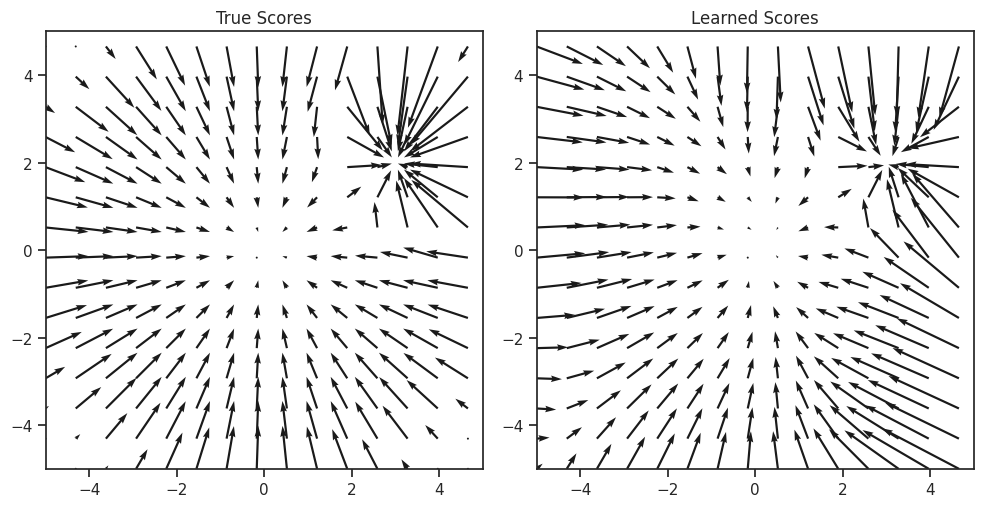

In [8]:
# Visualization function for learned scores
def visualize_learned_scores(mixture, score_net, grid_size=30, device='cpu'):
    """
    Visualize true and learned scores side by side
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Create grid for visualization
    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])

    # Compute true scores
    true_scores = mixture.score(points)
    true_scores_x = true_scores[:, 0].reshape(grid_size, grid_size)
    true_scores_y = true_scores[:, 1].reshape(grid_size, grid_size)

    # Compute learned scores
    score_net.eval()
    with torch.no_grad():
        learned_scores = score_net(torch.FloatTensor(points).to(device)).cpu().numpy()
    learned_scores_x = learned_scores[:, 0].reshape(grid_size, grid_size)
    learned_scores_y = learned_scores[:, 1].reshape(grid_size, grid_size)

    # Plot true scores
    skip = 2
    ax1.quiver(X[::skip, ::skip], Y[::skip, ::skip],
               true_scores_x[::skip, ::skip], true_scores_y[::skip, ::skip],
               scale=50, width=0.005)
    ax1.set_title("True Scores")

    # Plot learned scores
    ax2.quiver(X[::skip, ::skip], Y[::skip, ::skip],
               learned_scores_x[::skip, ::skip], learned_scores_y[::skip, ::skip],
               scale=50, width=0.005)
    ax2.set_title("Learned Scores")

    # Set consistent limits and labels
    for ax in [ax1, ax2]:
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_aspect('equal')
        ax.set_xlabel("")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()

# Visualize the results
visualize_learned_scores(mixture, score_net, device=device)

This motivates the non-trivial construction via the perturbed, conditional density: all steps required in the second equation can be computed efficiently. Hence, this gives a practical method for learning score functions, provided that we know a suitable value for $\sigma$.

This leads us to the next step, let's assume we have successfully trained  our network, how can we use ￼$\nabla_{\tilde{x}} \log p_\sigma(\tilde{x})$
to obtain a generative model for $p(x)$￼? That is, how can we produce actual samples $x$ with the score?

## Langevin Dynamics

_Langevin Dynamics_ are traditionally used for molecular systems with deterministic and stochastic forces.
It was shown there that iteration steps along the score, with just the right amount of additional perturbation at each step actually converge to samples from $p(x)$.

Specifically, for the update

$$
    x_{i+1} \leftarrow x_i + \epsilon \nabla_x \log p(x) + \sqrt{2 \epsilon} z_i
$$ (langevin)

with  $i = 0,1,..., K$  and  $z_i \sim \mathcal{N}(0, I)$,
the iterate $x_K$ converges to a sample from $p(x)$￼ as  $K \to \infty$  and $\epsilon \to 0$  under a set of regularity conditions.
For the theory, we should also consider how  $x_0$ was sampled from a distribution for  initialization, typically called￼$\pi(x)$.
For updating $x_i$, we can of course make use of the trained network $s_\theta$ to obtain the score $\nabla_x \log p(x)$ in each step of the iteration.

-overview image?-




### Langevin Dynamics Algorithm

In [9]:
def langevin_dynamics(score_net, n_steps=1000, n_samples=35, step_size=0.01):

    device = next(score_net.parameters()).device

    x = torch.linspace(-5, 5, n_samples)
    y = torch.linspace(-5, 5, n_samples)
    X, Y = torch.meshgrid(x, y)
    x = torch.stack([X.flatten(), Y.flatten()], dim=1)

    x = x.to(device)

    trajectory = [x.cpu().detach().numpy()]

    score_net.eval()
    with torch.no_grad():
        for step in range(n_steps):

            score = score_net(x)
            noise = torch.randn_like(x)
            x = x + step_size * score + np.sqrt(2 * step_size) * noise

            if step in [0, 100, 200, 300, 400, 500]:
                trajectory.append(x.cpu().detach().numpy())

    return trajectory


trajectory = langevin_dynamics(
    score_net,
    n_steps=501,    # run for 501 steps to include step 500
    n_samples=35,
    step_size=0.01,
)

samples =  trajectory[-1]

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Visualize the Trajectories

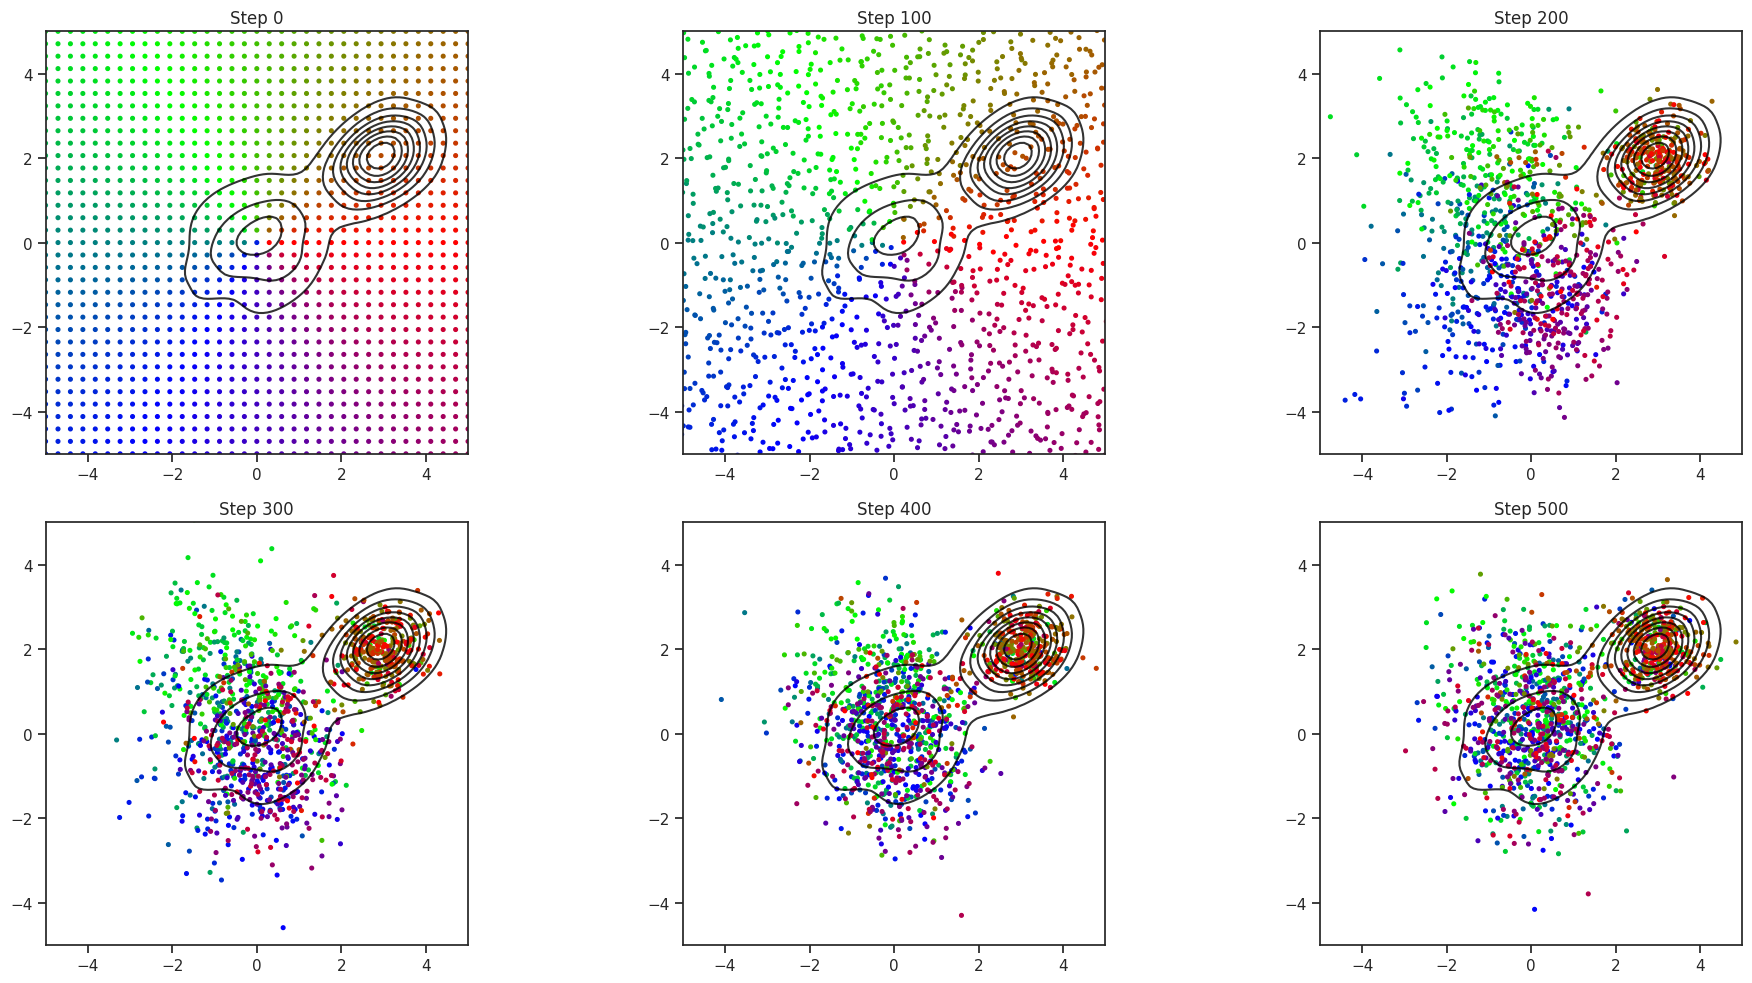

In [10]:
def get_angle_colors(positions):
    angles = np.arctan2(positions[:, 1], positions[:, 0])
    angles_deg = (np.degrees(angles) + 360) % 360
    colors = np.zeros((len(positions), 3))
    for i, angle in enumerate(angles_deg):
        segment = int(angle / 120)
        local_angle = angle - segment * 120
        if segment == 0:    # 0 degrees to 120 degrees (R->G)
            colors[i] = [1 - local_angle/120, local_angle/120, 0]
        elif segment == 1:  # 120 degrees to 240 degrees (G->B)
            colors[i] = [0, 1 - local_angle/120, local_angle/120]
        else:               # 240 degrees to 360° (B->R)
            colors[i] = [local_angle/120, 0, 1 - local_angle/120]

    return colors

def visualize_langevin_trajectory(trajectory, mixture, figsize=(20, 10)):

    n_plots = len(trajectory)
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.ravel()
    real_samples = mixture.sample(1000)
    from scipy.stats import gaussian_kde
    xx, yy = np.mgrid[-5:5:100j, -5:5:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    kernel = gaussian_kde(real_samples.T)
    density = np.reshape(kernel(positions).T, xx.shape)

    steps = [0, 100, 200, 300, 400, 500]

    for idx, (samples, step) in enumerate(zip(trajectory, steps)):
        ax = axes[idx]

        if idx == 0:
            c = get_angle_colors(samples)

        ax.contour(xx, yy, density, levels=10, alpha=0.8, colors='black')
        ax.scatter(samples[:, 0], samples[:, 1], alpha=1, s=7, color=c)

        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_aspect('equal')
        ax.set_title(f'Step {step}')

    plt.tight_layout()
    plt.show()

visualize_langevin_trajectory(trajectory, mixture)

## Annealed Langevin Dynamics

### Network and Dataset Definition with Noise Level

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class ScoreNetworkWithSigma(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for sigma
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, sigma):
        sigma = sigma.view(-1, 1)
        x_sigma = torch.cat([x, sigma], dim=1)
        return self.net(x_sigma)

class AnnealedDenoisingScoreMatchingDataset(Dataset):
    def __init__(self, gaussian_mixture, num_samples=10000, sigmas=[4.0, 2.0, 1.0, 0.5, 0.2, 0.01]):
        self.samples = torch.FloatTensor(gaussian_mixture.sample(num_samples))
        self.sigmas = sigmas

    def __len__(self):
        return len(self.samples) * len(self.sigmas)

    def __getitem__(self, idx):
        sample_idx = idx // len(self.sigmas)
        sigma_idx = idx % len(self.sigmas)

        x = self.samples[sample_idx]
        sigma = self.sigmas[sigma_idx]

        # Add noise to the sample
        noise = torch.randn_like(x) * sigma
        x_noisy = x + noise

        return x_noisy, noise, x, torch.tensor(sigma).float()

### Training

In [12]:
def train_annealed_score_network(model, train_loader, num_epochs=100, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (x_noisy, noise, x_clean, sigma) in enumerate(train_loader):
            x_noisy, noise = x_noisy.to(device), noise.to(device)
            sigma = sigma.to(device)

            optimizer.zero_grad()

            pred_score = model(x_noisy, sigma)

            target_score = -noise / (sigma.view(-1, 1) ** 2)
            loss = torch.mean(torch.sum((pred_score - target_score) ** 2, dim=1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

    return losses

sigmas = [4.0, 2.0, 1.0, 0.5, 0.2, 0.01]

dataset = AnnealedDenoisingScoreMatchingDataset(mixture, num_samples=10000, sigmas=sigmas)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
score_net = ScoreNetworkWithSigma().to(device)

losses = train_annealed_score_network(score_net, dataloader, num_epochs=100, device=device)

Epoch 10/100, Loss: 3306.6889
Epoch 20/100, Loss: 3374.6170
Epoch 30/100, Loss: 3296.4916
Epoch 40/100, Loss: 3328.9254
Epoch 50/100, Loss: 3302.5448
Epoch 60/100, Loss: 3362.3191
Epoch 70/100, Loss: 3349.0398
Epoch 80/100, Loss: 3337.2041
Epoch 90/100, Loss: 3354.9199
Epoch 100/100, Loss: 3328.9864


### Sampling with Langevin Dynamics and Noise Levels

In [13]:
def annealed_langevin_dynamics(score_net, sigmas,
                               n_steps_each=100, n_samples=1000,
                               step_size=0.001):
    device = next(score_net.parameters()).device

    x = torch.linspace(-10, 10, n_samples)
    x = torch.stack(torch.meshgrid(x, x), dim=-1).reshape(-1, 2)

    x = x.to(device)

    trajectory = [x.cpu().detach().numpy()]

    score_net.eval()
    with torch.no_grad():
        for sigma in sigmas:
            alpha = step_size * (sigma / sigmas[-1]) ** 2

            for step in range(n_steps_each):
                sigma_tensor = torch.full((n_samples*n_samples,), sigma, device=device)
                score = score_net(x, sigma_tensor)

                noise = torch.randn_like(x)
                x = x + alpha * score + np.sqrt(2 * alpha) * noise

            trajectory.append(x.cpu().detach().numpy())

    return trajectory

trajectory = annealed_langevin_dynamics(
        score_net,
        sigmas=sigmas,
        n_steps_each=150,
        n_samples=35,
        step_size=0.00001
        )

### Visualization of Trajectories

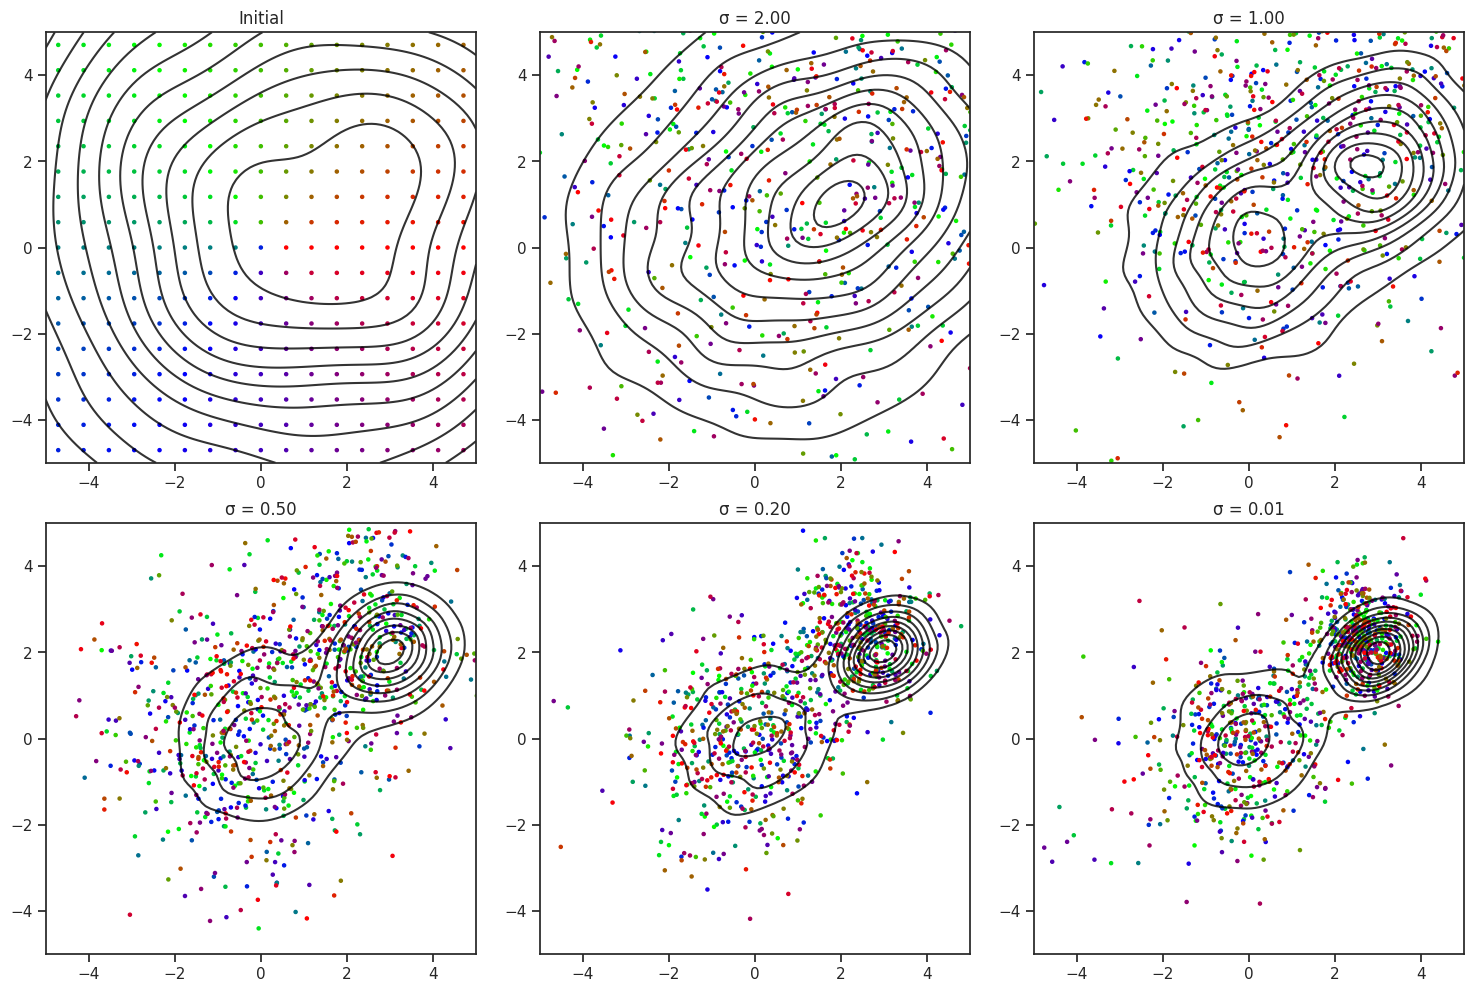

In [14]:
def visualize_annealed_langevin_trajectory(trajectory, mixture, sigmas, figsize=(15, 10)):

    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.ravel()

    from scipy.stats import gaussian_kde
    xx, yy = np.mgrid[-5:5:100j, -5:5:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    for idx, (samples, sigma) in enumerate(zip(trajectory, sigmas)):
        ax = axes[idx]

        if idx == 0:
            c = get_angle_colors(samples)

        real_samples = torch.tensor(mixture.sample(5000))
        real_samples += torch.randn_like(real_samples) * sigma

        kernel = gaussian_kde(real_samples.T)
        density = np.reshape(kernel(positions).T, xx.shape)

        ax.contour(xx, yy, density, levels=10, alpha=0.8, colors='black')

        ax.scatter(samples[:, 0], samples[:, 1], alpha=1.0, s=5, color=c)

        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_aspect('equal')
        ax.set_title(f'σ = {sigma:.2f}' if idx > 0 else 'Initial')

    plt.tight_layout()
    plt.show()

visualize_annealed_langevin_trajectory(trajectory, mixture, sigmas)

Now we're almost at the goal, but before making the last step to derive the famous "denoising" task, let's summarize the ground we've covered so far:
* Denoising score matching works well even for high-dimensional data such as images.
* There's no need to backpropagate gradients through many steps, i.e. the method is much more scalable than CNFs or NeuralODEs.
* We have a way to sample from $p(x)$ to produce samples without the need for assumptions in the form of non-trivial prior distributions.

Despite these important steps forward, we're left with a few challenging aspects:
* Specifying a good sequence of noise scales is critical, and unclear to obtain so far.
* We can sample from $p(x)$, but not directly compute likelihoods.
* The "convenient" maximum likelihood training is not applicable anymore.

There's also the practical aspect of performance: inference actually requires many evaluations of $s_\theta(x, \sigma_j)$, and this can make producing samples expensive. As a first step, we'll make sure we can get _accurate_ samples, but we'll also revisit the question of computational efficiency later on.